In [2]:
import pandas as pd
import numpy as np

In [16]:
from pykalman import KalmanFilter

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
import glob
%matplotlib inline
sns.set('notebook')
current_palette = sns.color_palette()

In [4]:
def load_grimm(folder):
    grimm = pd.read_csv(path.join(folder, 'DATA.TSV'), delimiter='\t',skiprows=7)
    grimm.index = [pd.to_datetime(grimm.Date[i]+' '+grimm.Time[i]) for i in range(len(grimm))]
    return grimm

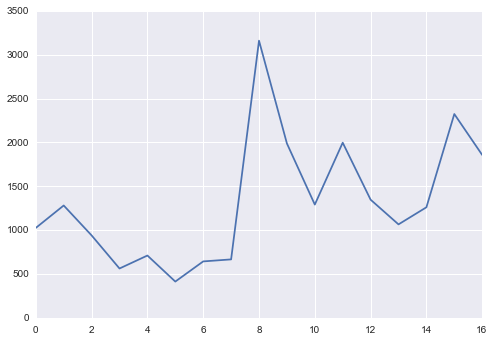

In [5]:
grimm = load_grimm('data/090915B')
plt.plot(grimm[u'2.0um'])

In [20]:
def load_specks(folder, time_offset=3600, cov=1075):
    specks = []
    for speck_file in glob.glob(path.join(folder, '*.csv')):
        speck = pd.read_csv(speck_file)
        speck.index = pd.to_datetime(speck['timestamp_utc_secs']+time_offset, unit='s')
        kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, transition_matrices=[[1]], observation_matrices=[[1]], observation_covariance=[[cov]], transition_covariance=[[1]])
        speck['filtered'] = kf.filter(speck.raw_particles.values)[0]
        speck.filtered = lfilter(b4,a4, speck.filtered)
        specks.append(speck)
    return specks

In [21]:
specks = load_specks('data/090915B/data')

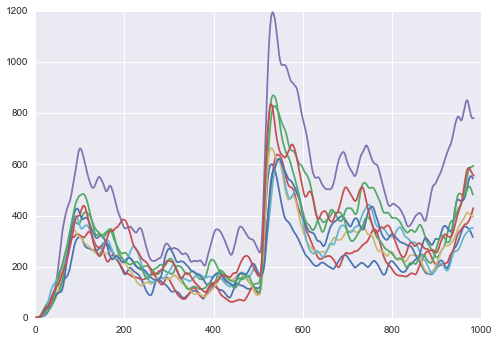

In [22]:
for speck in specks:
    plt.plot(speck.filtered)

In [23]:
def get_scale(speck, grimm):
    d = []
    scales = np.linspace(0,10,100)
    for x in scales:
        d.append(np.nanmean((x*speck.loc[grimm.index, 'filtered'] - grimm[u'2.0um'])**2))
    return min(zip(d, scales))


def get_scale_old(speck, grimm):
    d = []
    scales = np.linspace(20,40,60)
    for x in scales:
        d.append(np.nanmean((x*speck.loc[grimm.index, 'particle_concentration'] - grimm[u'2.0um'])**2))
    return min(zip(d, scales))

In [24]:
scales = [get_scale_old(speck, grimm) for speck in specks]
errors, scales = zip(*scales)


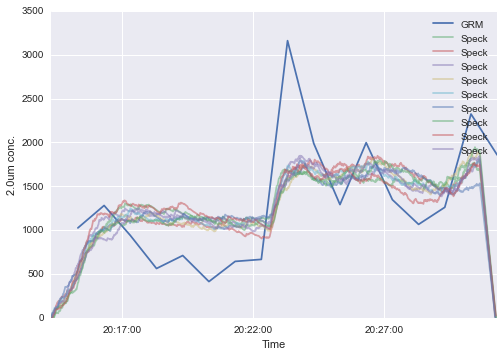

In [25]:
ax = plt.subplot(111)
ax.plot(grimm.index, grimm[u'2.0um'], label='GRM')

for scale, speck in zip(scales, specks):
    ax.plot(speck.index, speck.particle_concentration*scale, alpha=0.5, label='Speck')
    #ax.plot(speck.index, speck.filtered*scale, alpha=0.5, label='Speck')

plt.ylabel('2.0um conc.')
plt.xlabel('Time')
plt.legend()

In [26]:
scales = [get_scale(speck, grimm) for speck in specks]
errors, scales = zip(*scales)
sum(errors)

664247.51292585407

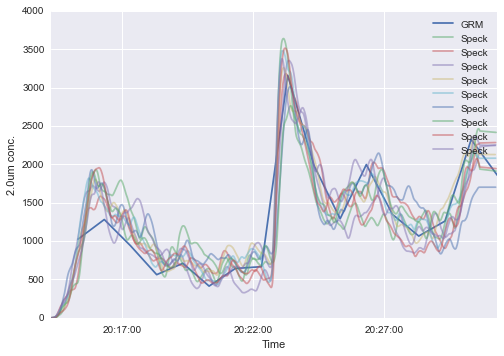

In [27]:
ax = plt.subplot(111)
ax.plot(grimm.index, grimm[u'2.0um'], label='GRM')

for scale, speck in zip(scales, specks):
    #ax.plot(speck.index, speck.particle_concentration*30, alpha=0.5)
    ax.plot(speck.index, speck.filtered*scale, alpha=0.5, label='Speck')

plt.legend()
plt.ylabel('2.0um conc.')
plt.xlabel('Time')
plt.legend()
plt.savefig('kf.pdf')

In [1928]:
def test_folder(folder, time_offset=3600):
    grimm = load_grimm(folder)
    specks = load_specks(path.join(folder,'data'), time_offset=time_offset)

    scales = [get_scale(speck, grimm) for speck in specks]
    errors, scales = zip(*scales)
    print errors
    ax = plt.subplot(111)
    ax.plot(grimm.index, grimm[u'2.0um'], label='GRM')

    for scale, speck in zip(scales, specks):
        ax.plot(speck.index, speck.filtered*scale, alpha=0.5, label='Speck')

    plt.legend()

(95661.540958321144, 77299.936072935976, 71828.167748134045, 37750.339302478023, 28095.835500983078, 110407.63731830945, 94842.81139441613, 92435.048046209442, 55926.196584066696)


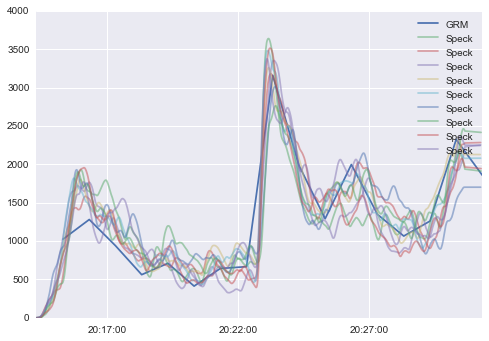

In [1929]:
test_folder('data/090915B')

(136719.69658367868, 168944.68700109248, 229099.65691632012, 128168.2107633421, 101512.57405333401, 149264.77015539599, 97660.129167416351, 351488.90977179806, 169317.64522261068)


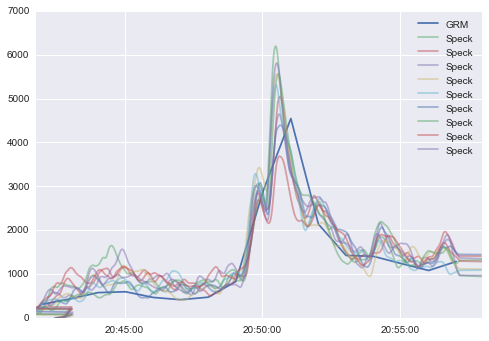

In [1930]:
test_folder('data/090915C', time_offset = 3600)

(160482.57682402426, 277343.15075399698, 177034.66745854568, 232435.90682084052, 270185.52370622545, 477878.85821799742, 343843.996669552, 217566.24387537321, 138491.84105838084)


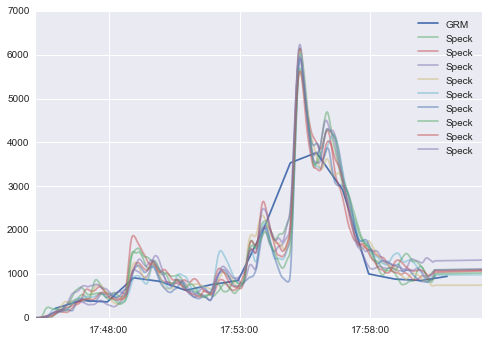

In [1931]:
test_folder('data/092115A')

(56740.738264933621, 48302.527450758018, 1197294.5397712125, 76245.083527931449, 58241.682033852441, 143800.02065786102, 54044.217633835178, 77033.773171741705, 65415.426773158164)


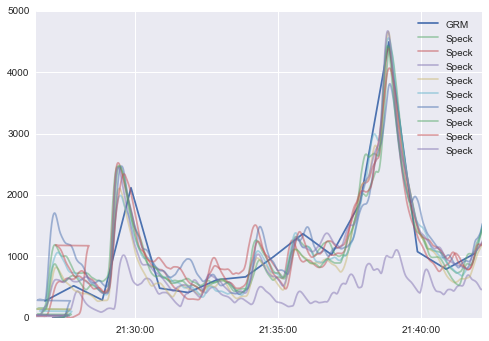

In [1940]:
test_folder('data/091115C', time_offset=3600)

(48397.892866700699, 30409.545062126748, 40452.843099615457, 63952.682691118964, 81503.505101751056, 72087.521369789654, 48299.891431952215, 55839.935922069089, 44957.100519807165)


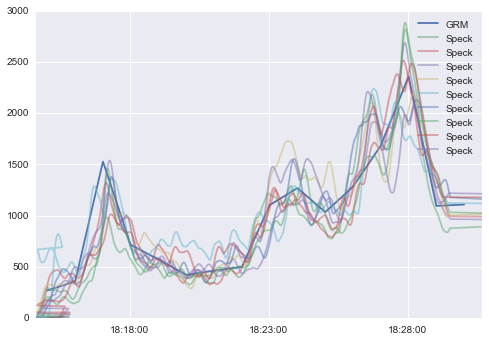

In [1933]:
test_folder('data/091415B')

(256715.16178863784, 590165.306245349, 719400.31616055127, 247928.44016005006, 168266.16391329651, 245018.10464051989, 371121.13970904425, 398357.95347896474, 486174.59110047726)


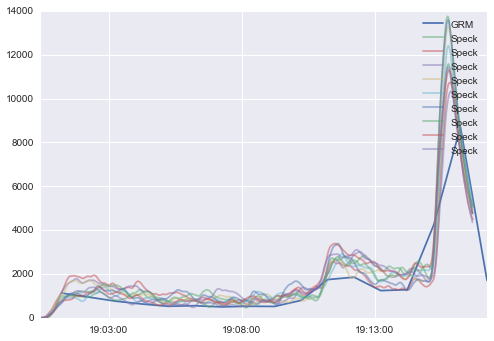

In [1934]:
test_folder('data/091615A', time_offset=3600)

(61841.114386494206, 83355.450363460986, 235106.5512176484, 49268.948067630961, 51557.975453852006, 50195.435487199087, 48235.005097069421, 55217.374246967316, 21850.470327280804)


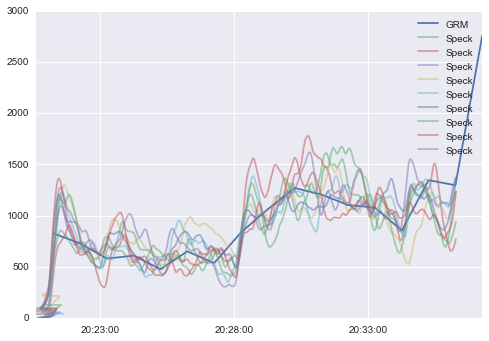

In [1935]:
test_folder('data/091815A/')

(35923.778522082801, 38443.583467873003, 59045.8174973524, 29407.768021995718, 21587.189169484842, 40249.622281058131, 29812.315880970484, 35288.450287892498, 33034.747432185111)


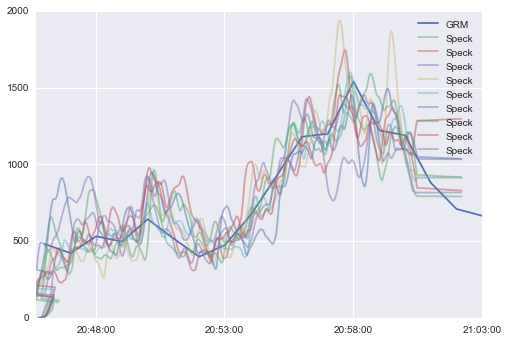

In [1936]:
test_folder('data/091815B/')

(160482.57682402426, 277343.15075399698, 177034.66745854568, 232435.90682084052, 270185.52370622545, 477878.85821799742, 343843.996669552, 217566.24387537321, 138491.84105838084)


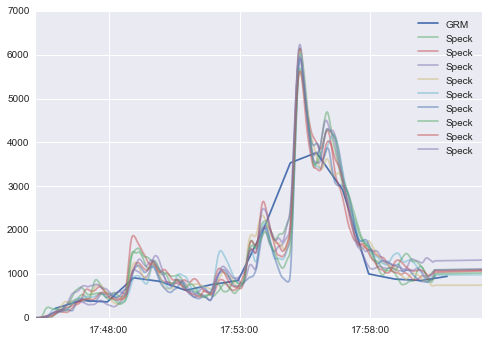

In [1937]:
test_folder('data/092115A')

(91785.503640444382, 119552.28063442423, 103759.39456874724, 74987.933933044798, 85675.058805638342, 109498.80736090247, 81933.399677611596, 134171.71626366914, 82391.777724183339)


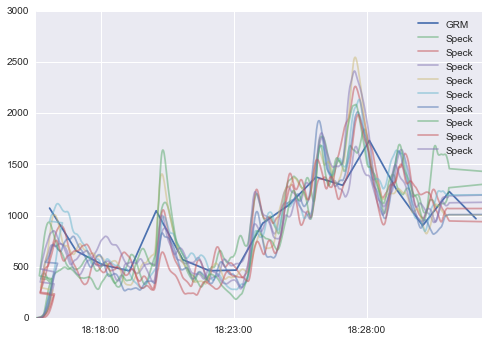

In [1938]:
test_folder('data/092115B/')

(47441.711943267488, 41911.349238915456, 237113.83454063727, 31751.999830506666, 81215.559398648635, 12306.819897024516, 33391.48128089901, 70361.707979730607, 39682.024484432302)


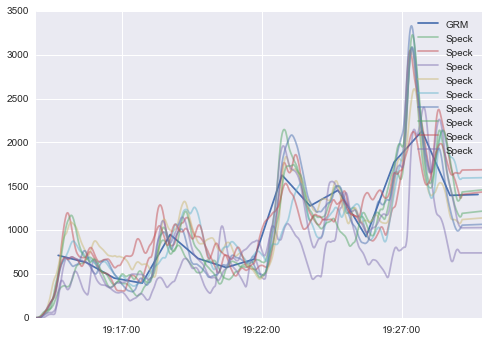

In [1939]:
test_folder('data/092115C/')

In [28]:
speck_file = 'data/090915B/data/005c1edb461329d5778036f7d7627a22.csv'
speck = pd.read_csv(speck_file)
speck.index = pd.to_datetime(speck['timestamp_utc_secs']+3600, unit='s')

In [29]:
gamma=1
sigmaz=1e6
sigmaa=1e0
kf2 = KalmanFilter(n_dim_obs=1, n_dim_state=2, 
                  initial_state_mean=[0,0], 
                  transition_matrices=[[1,1],[0,1]], 
                  observation_matrices=[1,0], 
                  observation_covariance=[sigmaz], 
                  transition_covariance=[[0.25*sigmaa,0.5*sigmaa],[0.5*sigmaa,1*sigmaa]])


In [30]:
kf1 = KalmanFilter(initial_state_mean=0, n_dim_obs=1, transition_matrices=[[1]], observation_matrices=[[1]], observation_covariance=[[1e4]], transition_covariance=[[1e1]])

In [31]:
specks = [speck]
specks.append(speck.copy())
specks.append(speck.copy())
specks.append(speck.copy())
specks.append(speck.copy())

In [176]:
from scipy.signal import lfilter, cheby1, cheby2, butter
#b, a = butter(2, 0.02)
#b2, a2 = butter(2, 0.05)
b, a =   cheby1(1, 0.5, 0.05)
b2, a2 = cheby1(2, 0.5, 0.01)
b3, a3 = cheby1(2, 0.5, 0.06)

b4, a4 = butter(1, [0.03, 0.95], btype='bandstop')

In [177]:
specks[0]['filtered'] = kf1.filter(specks[0].raw_particles.values)[0]
specks[1]['filtered'] = kf1.smooth(specks[0].raw_particles.values)[0]
specks[2]['filtered'] = lfilter(b2,a2, specks[0].raw_particles.values)
specks[3]['filtered'] = lfilter(b3,a3, specks[0].filtered)
specks[4]['filtered'] = lfilter(b4,a4,specks[3].filtered)

In [178]:
scales = [get_scale(speck, grimm)[1] for speck in specks]
errors = [get_scale(speck, grimm)[0] for speck in specks]

In [179]:
errors

[82693.059072898133,
 228349.14778691158,
 127707.20965617057,
 93690.501669876801,
 110225.58703795035]

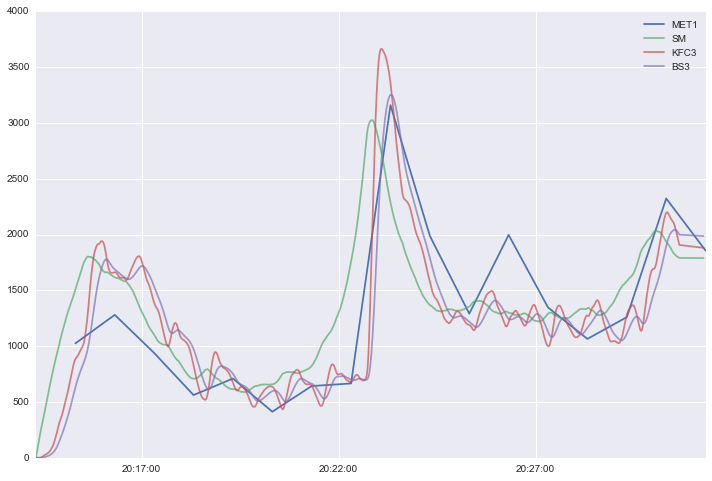

In [180]:
plt.figure(figsize=(12,8))
time = specks[0].index 
plt.plot(grimm.index, grimm[u'2.0um'], label='MET1')
#plt.plot(time, scales[0]*specks[0].filtered, alpha=0.5, label='KF')
plt.plot(time, scales[1]*specks[1].filtered, alpha=0.7, label='SM')
#plt.plot(time, scales[2]*specks[2].filtered, alpha=0.5, label='CC')
plt.plot(time, scales[3]*specks[3].filtered, alpha=0.7, label='KFC3')
plt.plot(time, scales[4]*specks[4].filtered, alpha=0.7, label='BS3')
plt.legend()

In [175]:
for speck in specks:
    print max(zip(speck.filtered,speck.index))

(634.05024969849785, Timestamp('2015-09-09 20:23:07'))
(507.616828039567, Timestamp('2015-09-09 20:22:51'))
(613.23154021769687, Timestamp('2015-09-09 20:23:25'))
(604.68976387695295, Timestamp('2015-09-09 20:23:05'))
(546.25694729529721, Timestamp('2015-09-09 20:23:20'))
